# Modtran Tape7 Data Analysis

In [15]:
###
import os
import numpy as np
import pandas as pd
from scipy.interpolate import  interp1d
import matplotlib.colors as mcolors

import pyradi.ryplot as ryplot
import pyradi.ryplanck as ryplanck
import pyradi.rymodtran as rymodtran
import pyradi.ryutils as ryutils

## Modtran Runs

The purpose with this document is to investigate the definitions of the column data in Modtran tape7 files, in order to clarify the meaning of each of the columns.  Modtran 5 was used for this analysis.

The notebook and data files are in the \url{modtranSolarIrrad} folder in the \url{https://github.com/NelisW/ComputationalRadiometry.git} repository.

Several different path geometries were investigated, all for the same atmospheric model. The atmospheric model used here is not important, it merely serves as common model. For reference, this model has custom vertical profiles with max altitude of 30.03~km, with high ground temperature and 10 km visibility Navy Maritime aerosol, and specifies the standard Modtran Desert albedo.

Note that Modtran does not assume any vertical profile values higher than the highest given profile data in tape5, longer/higher paths are truncated to the upper limit in the profile.

## Result Files

The path geometries with identifiers are shown in Figure~\ref{fig:pathgeometry01}.

![](images/pathgeometry01.png)

|Run |ID|Path | H1 | H2 | Zenith | 
| --| ---| ---| ---|---|--|
|obs |o |slant path | 12.027|0.027| 118.8|
|low |l |slant path | 0.037 | 0.027| 118.8|
|med |m |slant path | 3 | 0.027| 118.8|
|sun |s |slant path to space | 0.027|30.03 | 21.33 |
|upp |u |slant path to space | 30.03|0.027  |180 |

The Modtran tape6 files reported the follwoing path calculations:

obs

     SUMMARY OF LINE-OF-SIGHT No.  1 GEOMETRY CALCULATION

              H1ALT   =   12.02700 KM
              H2ALT   =    0.02700 KM
              OBSZEN  =  118.80000 DEG
              HRANGE  =   24.98084 KM
              ECA     =    0.19685 DEG
              BCKZEN  =   61.37925 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.01760 DEG
              CKRANG  =    0.00000 KM
              LENN    =          0


low 

     SUMMARY OF LINE-OF-SIGHT No.  1 GEOMETRY CALCULATION

              H1ALT   =    0.03700 KM
              H2ALT   =    0.02700 KM
              OBSZEN  =  118.80000 DEG
              HRANGE  =    0.02076 KM
              ECA     =    0.00016 DEG
              BCKZEN  =   61.20023 DEG
              HMIN    =    0.02700 KM
              BENDING =   -0.00006 DEG
              CKRANG  =    0.00000 KM
              LENN    =          0



med 

     SUMMARY OF LINE-OF-SIGHT No.  1 GEOMETRY CALCULATION

              H1ALT   =    3.00000 KM
              H2ALT   =    0.02700 KM
              OBSZEN  =  118.80000 DEG
              HRANGE  =    6.17544 KM
              ECA     =    0.04866 DEG
              BCKZEN  =   61.24339 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.00527 DEG
              CKRANG  =    0.00000 KM
              LENN    =          0


sun  (highest layer at 30.03 km)

     SUMMARY OF LINE-OF-SIGHT No.  1 GEOMETRY CALCULATION

              H1ALT   =    0.02700 KM
              H2ALT   =   30.03000 KM
              OBSZEN  =   21.33000 DEG
              HRANGE  =   32.19862 KM
              ECA     =    0.10485 DEG
              BCKZEN  =  158.76952 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.00532 DEG
              CKRANG  =    0.00000 KM
              LENN    =          0

upp  (highest layer at 30.03 km)

     SUMMARY OF LINE-OF-SIGHT No.  1 GEOMETRY CALCULATION

              H1ALT   =   30.03000 KM
              H2ALT   =    0.02700 KM
              OBSZEN  =  180.00000 DEG
              HRANGE  =   30.00300 KM
              ECA     =    0.00000 DEG
              BCKZEN  =    0.00000 DEG
              HMIN    =    0.02700 KM
              BENDING =    0.00000 DEG
              CKRANG  =    0.00000 KM
              LENN    =          0


In [16]:
## to define the display text for each path
dicPaths = {
'o':['[o] obs H1=12, H2=0.027, OBSZEN=118, HRANGE=25 km','g'],
'l':['[l] low H1=0.037, H2=0.027, OBSZEN=118, HRANGE=0.02 km','y'],
'm':['[m] low H1=3, H2=0.027, OBSZEN=118, HRANGE=6.2 km','c'],
's':['[s] sun H1=0.027, H2=30, OBSZEN=21, HRANGE=32.2 km','r'],
'u':['[u] upp H1=30, H2=0.027, OBSZEN=180, HRANGE=30 km','b']
}

In [17]:
## to define a function to load and interpolate the tape7 files
def loadinter(filename,wli):
    tape7 = rymodtran.loadtape7(filename, ['FREQ', 'REF_SOL','DEPTH','SOL@OBS','GRND_RFLT','DRCT_RFLT',
                                          'PTH_THRML','THRML_SCT','SURF_EMIS','SOL_SCAT','SING_SCAT','TOTAL_RAD','TOA_SUN'] )
    
    waven = tape7[:,0]

    # transmittance observer to ground
    tau = np.exp(-tape7[:,2])
    intfn = interp1d(1e4/waven,tau)
    tau = intfn(wli).reshape(-1,1)
    
    # convert from cm2 to m2
    # convert to per micron spectral density and interpolate to new vector
    (wavel, refsol) = ryutils.convertSpectralDensity(waven, tape7[:,1]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, solobs) = ryutils.convertSpectralDensity(waven, tape7[:,3]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, grndrflt) = ryutils.convertSpectralDensity(waven, tape7[:,4]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, drctrflt) = ryutils.convertSpectralDensity(waven, tape7[:,5]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)

    (wavel, pththrml) = ryutils.convertSpectralDensity(waven, tape7[:,6]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, thrmlsct) = ryutils.convertSpectralDensity(waven, tape7[:,7]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, surfemis) = ryutils.convertSpectralDensity(waven, tape7[:,8]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, solscat) = ryutils.convertSpectralDensity(waven, tape7[:,9]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, singscat) = ryutils.convertSpectralDensity(waven, tape7[:,10]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, totalrad) = ryutils.convertSpectralDensity(waven, tape7[:,11]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)
    (wavel, toasun) = ryutils.convertSpectralDensity(waven, tape7[:,12]*1e4, 'nl',outspecdomainFix=True,outspecdomain=wli)
   
    return wavel, tau, refsol, solobs, grndrflt, drctrflt,pththrml,thrmlsct,surfemis,solscat,singscat,totalrad,toasun


The `FREQ`, `REF SOL`,`DEPTH`,`SOL@OBS`,`GRND RFLT`,`DRCT RFLT`, `PTH THRML`,`THRML SCT`,`SURF EMIS`,`SOL SCAT`,`SING SCAT`,`TOTAL RAD`, `TOA SUN` columns are read from the Modtran tape7 files, for each of the paths.  
The Modtran spectral albedo for Desert was extracted from the Modtran data folders and read here. 
The Wehrli standard extraterrestrial (TOA) solar irradiance values are also read from a data file (\url{https://www.nrel.gov/grid/solar-resource/spectra-wehrli.html}). 
A very simple blackbody model is used to calculate the model for TOA extraterrestrial solar irradiance.  The extraterrestial irradiance for the Wehrli model and the simple blackbody model are shown in Figure~\ref{fig:SOLOBS-0}.

In [18]:
## to load all the data
numpts = 100
wli = np.append(np.linspace(1e4/33333.0, 1e4/10000,numpts),np.linspace(1e4/3333.3, 1e4/833.,numpts))

tau = {}
wavel = {}
refsol = {}
solobs = {}
grndrflt = {}
drctrflt = {}
pththrml = {}
thrmlsct = {}
surfemis = {}
solscat = {}
singscat = {}
totalrad = {} 
toasun = {} 

wavel['o'], tau['o'], refsol['o'], solobs['o'], grndrflt['o'], drctrflt['o'],pththrml['o'],thrmlsct['o'],surfemis['o'],solscat['o'],singscat['o'],totalrad['o'],toasun['o'] = loadinter('data/obs/tape5.tp7',wli)
wavel['l'], tau['l'], refsol['l'], solobs['l'], grndrflt['l'], drctrflt['l'],pththrml['l'],thrmlsct['l'],surfemis['l'],solscat['l'],singscat['l'],totalrad['l'],toasun['l'] = loadinter('data/low/tape5.tp7',wli)
wavel['m'], tau['m'], refsol['m'], solobs['m'], grndrflt['m'], drctrflt['m'],pththrml['m'],thrmlsct['m'],surfemis['m'],solscat['m'],singscat['m'],totalrad['m'],toasun['m'] = loadinter('data/med/tape5.tp7',wli)
wavel['s'], tau['s'], refsol['s'], solobs['s'], grndrflt['s'], drctrflt['s'],pththrml['s'],thrmlsct['s'],surfemis['s'],solscat['s'],singscat['s'],totalrad['s'],toasun['s'] = loadinter('data/sun/tape5.tp7',wli)
wavel['u'], tau['u'], refsol['u'], solobs['u'], grndrflt['u'], drctrflt['u'],pththrml['u'],thrmlsct['u'],surfemis['u'],solscat['u'],singscat['u'],totalrad['u'],toasun['u'] = loadinter('data/upp/tape5.tp7',wli)

albedod = np.loadtxt('data/albedo.dat')
intfn = interp1d(albedod[:,0],albedod[:,1])
albedo = intfn(wavel['o']).reshape(-1,1)
emisalb = (1- albedo.reshape(-1,) ) 

wehrli85d = np.loadtxt('data/wehrli85.txt',skiprows=3)
intfn = interp1d(wehrli85d[:,0]/1000.,wehrli85d[:,1]*1000.)
wehrli85 = intfn(wavel['o']).reshape(-1,1) 

toasun = toasun['u']

Tsun = 5850
Esun = 2.17e-5 * ryplanck.planck(wavel['o'],Tsun,'el') 

Tsurf = 321.20
Lsurf = (emisalb * ryplanck.planck(wavel['o'],Tsurf,'el') / np.pi).reshape(-1,1)
LTsky = ( ryplanck.planck(wavel['o'],Tsurf,'el') / np.pi).reshape(-1,1)


## Results 

The path transmittance values are shown in Figure~\ref{fig:pathtransmittance}.  Each line in the plot is identified by the summary path definitions.

The relative ratios of transmittance values agree with absorber amounts expected for the different path lengths and slant angles.

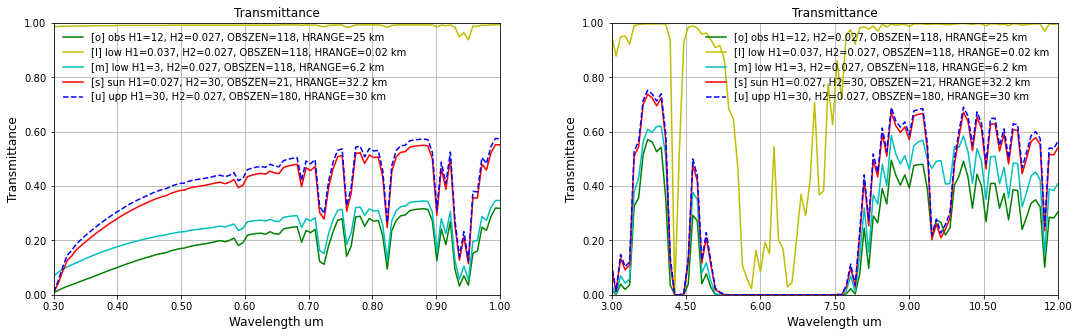

In [19]:
## to plot transmittance data
pltaxs = [[0.3,1,0,1],[3,12,0,1]] 
p = ryplot.Plotter(1, 1,2, figsize=(18,5))
for ip,pltax in enumerate(pltaxs):
    p.plot(ip+1,wavel['o'],tau['o'],label=[dicPaths['o'][0]],plotCol=dicPaths['o'][1])
    p.plot(ip+1,wavel['o'],tau['l'],label=[dicPaths['l'][0]],plotCol=dicPaths['l'][1])
    p.plot(ip+1,wavel['o'],tau['m'],label=[dicPaths['m'][0]],plotCol=dicPaths['m'][1])
    p.plot(ip+1,wavel['o'],tau['s'],label=[dicPaths['s'][0]],plotCol=dicPaths['s'][1])
    p.plot(ip+1,wavel['o'],tau['u'],label=[dicPaths['u'][0]],plotCol=dicPaths['u'][1],linestyle=['--'],
               ptitle='Transmittance',xlabel='Wavelength um',ylabel='Transmittance',
           pltaxis=pltax,maxNX=8);



Figure~\ref{fig:toasun} shows the top-of-atmosphere irradiance for the Modtran data in the tape7, the Wehrli model and the simple black body model.


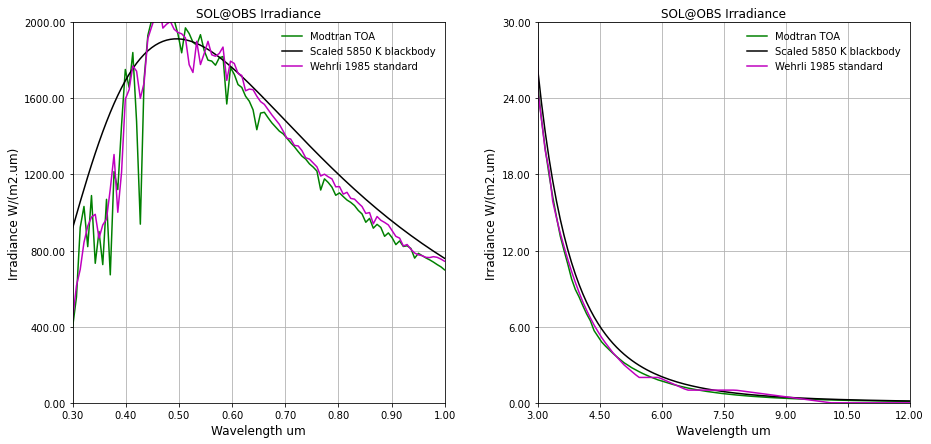

In [20]:
## to plot TOA data
r = ryplot.Plotter(1, 1, 2, figsize=(15,7))
pltaxs = [[0.3,1,0,2000],[3,12,0,30]] 
for ip,pltax in enumerate(pltaxs):
    r.plot(ip+1,wavel['o'],toasun,label=['Modtran TOA'],plotCol=dicPaths['o'][1])
    r.plot(ip+1,wavel['o'],Esun,plotCol='k',label=[f'Scaled {Tsun} K blackbody'])
    r.plot(ip+1,wavel['o'],wehrli85,plotCol='m',label=[f'Wehrli 1985 standard'],
           ptitle='SOL@OBS Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
           pltaxis=pltax,maxNX=8);

Figure~\ref{fig:SOLOBS} shows `SOL@OBS`: the  irradiance at the obsever, as well as the Modtran TOA irradiance values.

Note that the two cases with high altitude `H1` values (o and u) have irradiance values close to the TOA irradiance.  We can therefore conclude that `SOL@OBS` includes the path transmittance from the sun to the observer at `H1`.

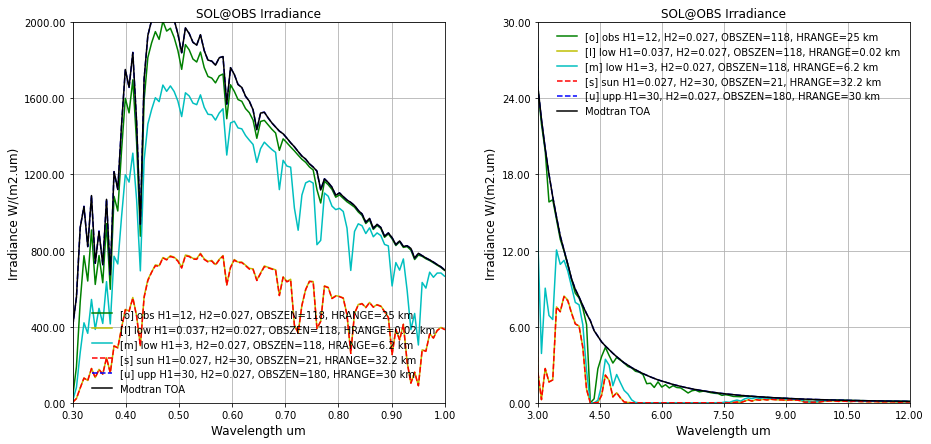

In [21]:
## to plot SOL@OBS data
r = ryplot.Plotter(1, 1, 2, figsize=(15,7))
pltaxs = [[0.3,1,0,2000],[3,12,0,30]] 
for ip,pltax in enumerate(pltaxs):
    # r.plot(1,wavel['o'],solobso*taus,label=['solobso*taus'],plotCol='m')
    r.plot(ip+1,wavel['o'],solobs['o'],label=[dicPaths['o'][0]],plotCol=dicPaths['o'][1])
    r.plot(ip+1,wavel['o'],solobs['l'],label=[dicPaths['l'][0]],plotCol=dicPaths['l'][1])
    r.plot(ip+1,wavel['o'],solobs['m'],label=[dicPaths['m'][0]],plotCol=dicPaths['m'][1])
    r.plot(ip+1,wavel['o'],solobs['s'],label=[dicPaths['s'][0]],plotCol=dicPaths['s'][1],linestyle=['--'])
    r.plot(ip+1,wavel['o'],solobs['u'],label=[dicPaths['u'][0]],plotCol=dicPaths['u'][1],linestyle=['--'])
    r.plot(ip+1,wavel['o'],toasun,plotCol='k',label=[f'Modtran TOA'],
           ptitle='SOL@OBS Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
           pltaxis=pltax,maxNX=8);

Figures~\ref{fig:REFSOL-0} and \ref{fig:REFSOL-1} show that `REFSOL` appears to be the unity-albedo ground-reflected solar irradiance at `H1`.  This is 
$$\textrm{REFSOL} = \tau_\textrm{sun}\tau_\textrm{path} \textrm{E}_\textrm{extra-terr}
$$
Upward looking paths (such as `sun`) do not provide relevant `REFSOL` values and is not considered here.

There is a reasonably good match  for all the cases between the Modtran results (solid colour lines) and the first-principles calculation using Modtran TOA irradiance and the Modtran transmittance values (black dashed lines).

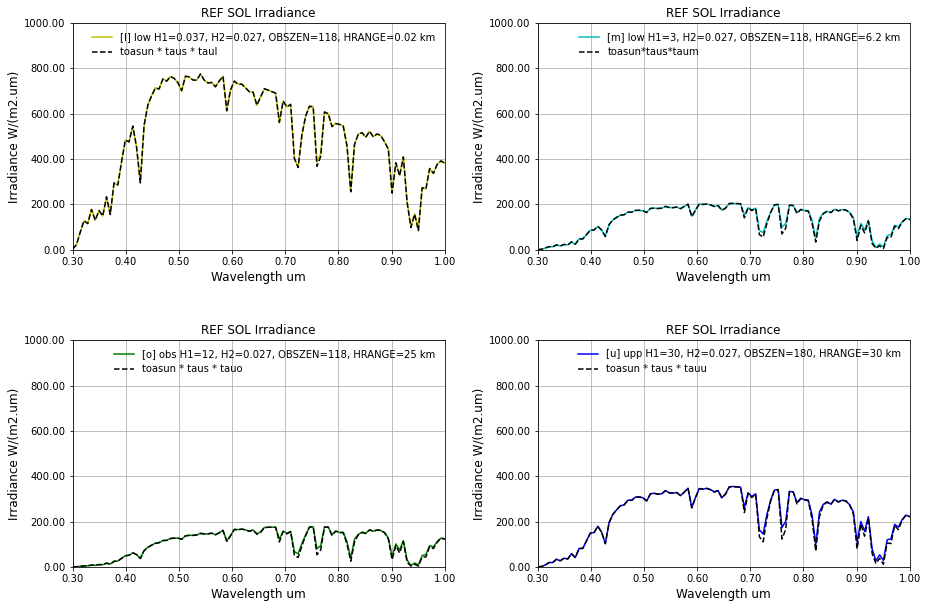

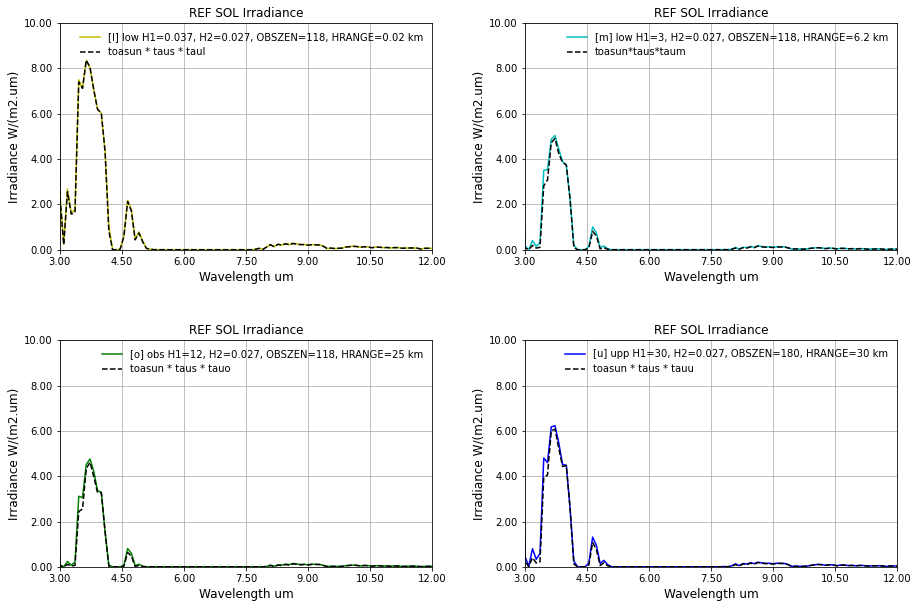

In [22]:
## to plot REFSOL data
pltaxs = [[0.3,1,0,1000],[3,12,0,10]] 
for ip,pltax in enumerate(pltaxs):
    r = ryplot.Plotter(1+ip, 2, 2, figsize=(15,10))

    r.plot(1,wavel['o'],refsol['l'],label=[dicPaths['l'][0]],plotCol=dicPaths['l'][1])
    r.plot(1,wavel['o'],toasun*tau['s']*tau['l'],label=['toasun * taus * taul'],plotCol='k',linestyle=['--'],
        ptitle='REF SOL Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(2,wavel['o'],refsol['m'],label=[dicPaths['m'][0]],plotCol=dicPaths['m'][1])
    r.plot(2,wavel['o'],toasun*tau['s']*tau['m'],label=['toasun*taus*taum'],plotCol='k',linestyle=['--'],
        ptitle='REF SOL Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(3,wavel['o'],refsol['o'],label=[dicPaths['o'][0]],plotCol=dicPaths['o'][1])
    r.plot(3,wavel['o'],toasun*tau['s']*tau['o'],label=['toasun * taus * tauo'],plotCol='k',linestyle=['--'],
        ptitle='REF SOL Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(4,wavel['o'],refsol['u'],label=[dicPaths['u'][0]],plotCol=dicPaths['u'][1])
    r.plot(4,wavel['o'],toasun*tau['s']*tau['u'],label=['toasun * taus * tauu'],plotCol='k',linestyle=['--'],
        ptitle='REF SOL Irradiance',xlabel='Wavelength um',ylabel='Irradiance W/(m2.um)',
        pltaxis=pltax,maxNX=8);


Figures~\ref{fig:DRCTRFLT-0}  and \ref{fig:DRCTRFLT-1} show that `DRCT RFLT` appears to be the apparent ground radiance at `H2` as observed from `H1`. With non-unity-albedo ground-reflected solar (only) irradiance. This is 

$$
\textrm{DRCT RFLT} = \alpha\tau_\textrm{sun}\tau_\textrm{path} \textrm{E}_\textrm{extra-terr}/\pi
$$

Upward looking paths (such as `sun`) do not provide relevant `DRCT RFLT`  values and is not considered here.

There is a reasonable match  for all the cases between the Modtran results (solid colour lines) and the first-principles calculation using the Modtran TOA irradiance  and the Modtran transmittance values (black dashed lines).

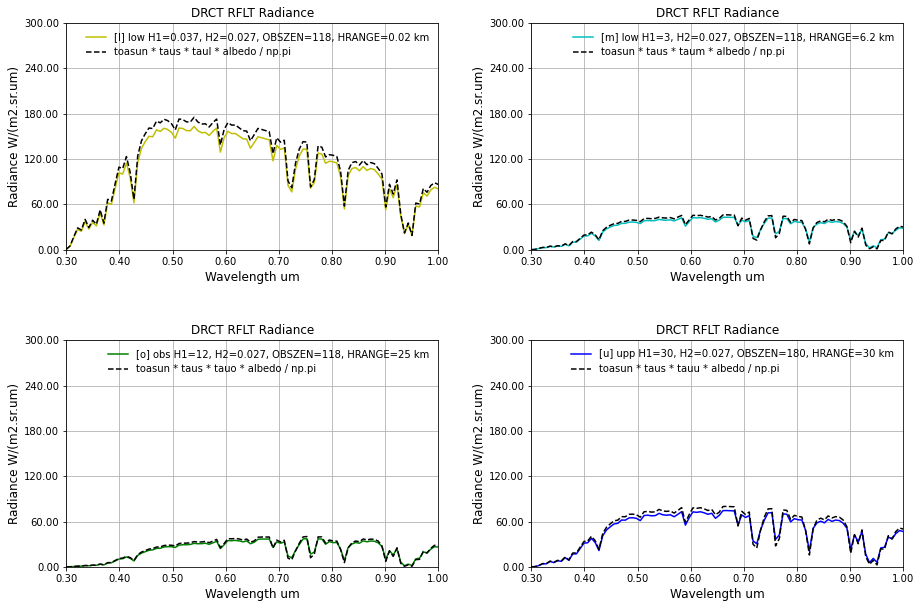

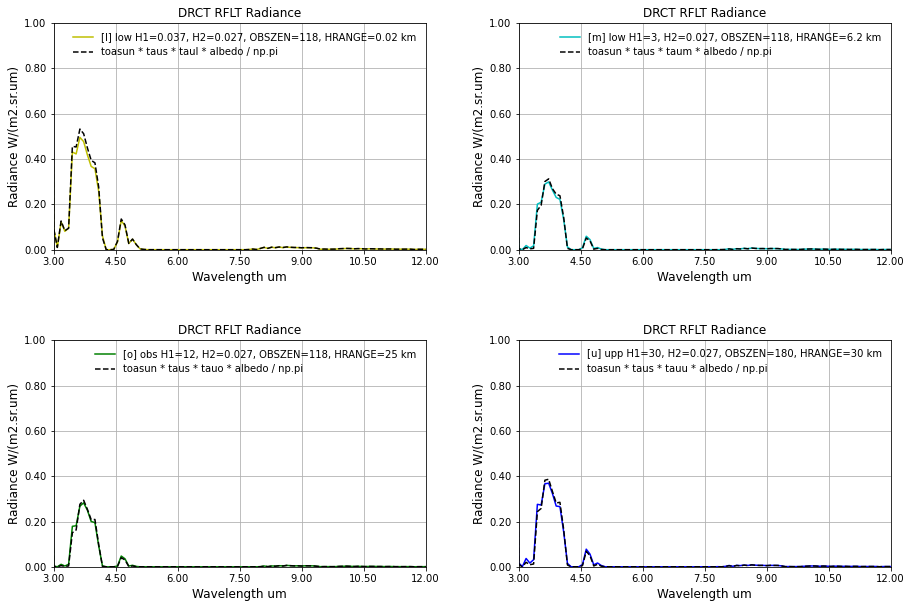

In [23]:
## to plot DRCT RFLT data
pltaxs = [[0.3,1,0,300],[3,12,0,1]] 
for ip,pltax in enumerate(pltaxs):
    r = ryplot.Plotter(1+ip, 2, 2, figsize=(15,10))


    r.plot(1,wavel['o'],drctrflt['l'],label=[dicPaths['l'][0]],plotCol=dicPaths['l'][1])
    r.plot(1,wavel['o'],toasun*tau['s']*tau['l']*albedo/np.pi,label=['toasun * taus * taul * albedo / np.pi'],plotCol='k',linestyle=['--'],
        ptitle='DRCT RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(2,wavel['o'],drctrflt['m'],label=[dicPaths['m'][0]],plotCol=dicPaths['m'][1])
    r.plot(2,wavel['o'],toasun*tau['s']*tau['m']*albedo/np.pi,label=['toasun * taus * taum * albedo / np.pi'],plotCol='k',linestyle=['--'],
        ptitle='DRCT RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(3,wavel['o'],drctrflt['o'],label=[dicPaths['o'][0]],plotCol=dicPaths['o'][1])
    r.plot(3,wavel['o'],toasun*tau['s']*tau['o']*albedo/np.pi,label=['toasun * taus * tauo * albedo / np.pi'],plotCol='k',linestyle=['--'],
        ptitle='DRCT RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(4,wavel['o'],drctrflt['u'],label=[dicPaths['u'][0]],plotCol=dicPaths['u'][1])
    r.plot(4,wavel['o'],toasun*tau['s']*tau['u']*albedo/np.pi,label=['toasun * taus * tauu * albedo / np.pi'],plotCol='k',linestyle=['--'],
        ptitle='DRCT RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

Figures~\ref{fig:SURFEMIS-0} and \ref{fig:SURFEMIS-1}  show that `SURF EMIS` is a radiance value calculated as $\tau_\textrm{H1Hground} (1-\alpha) L(T_\textrm{ground})$. The values in the NIR band are insignificant because the ground does not radiate in the NIR band.

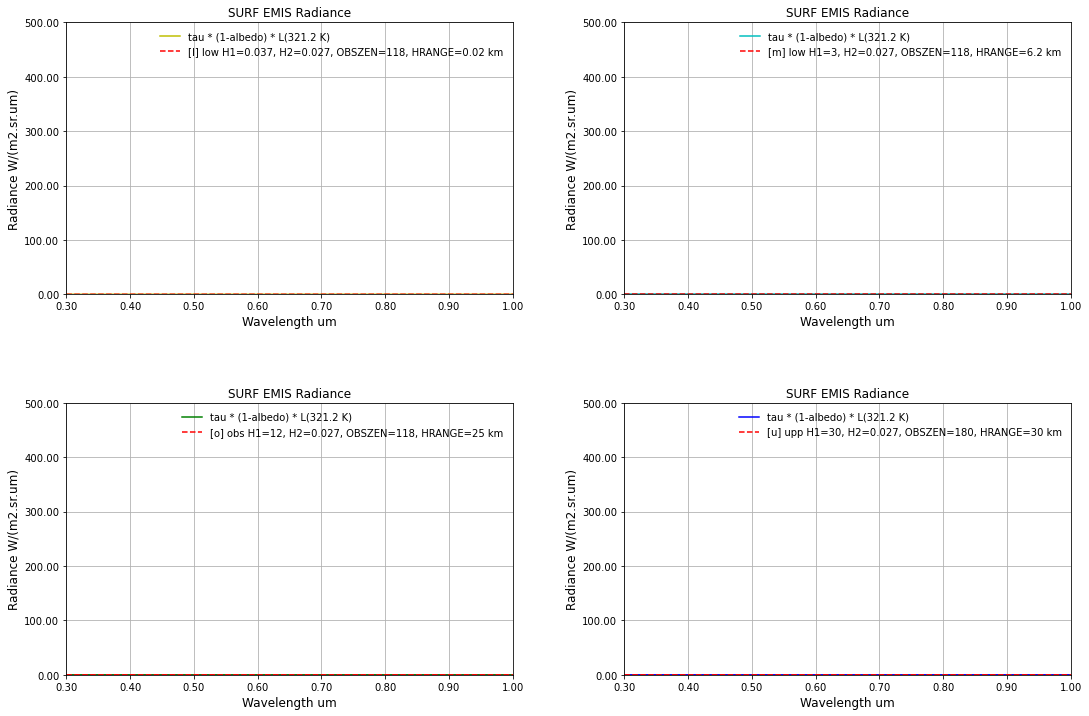

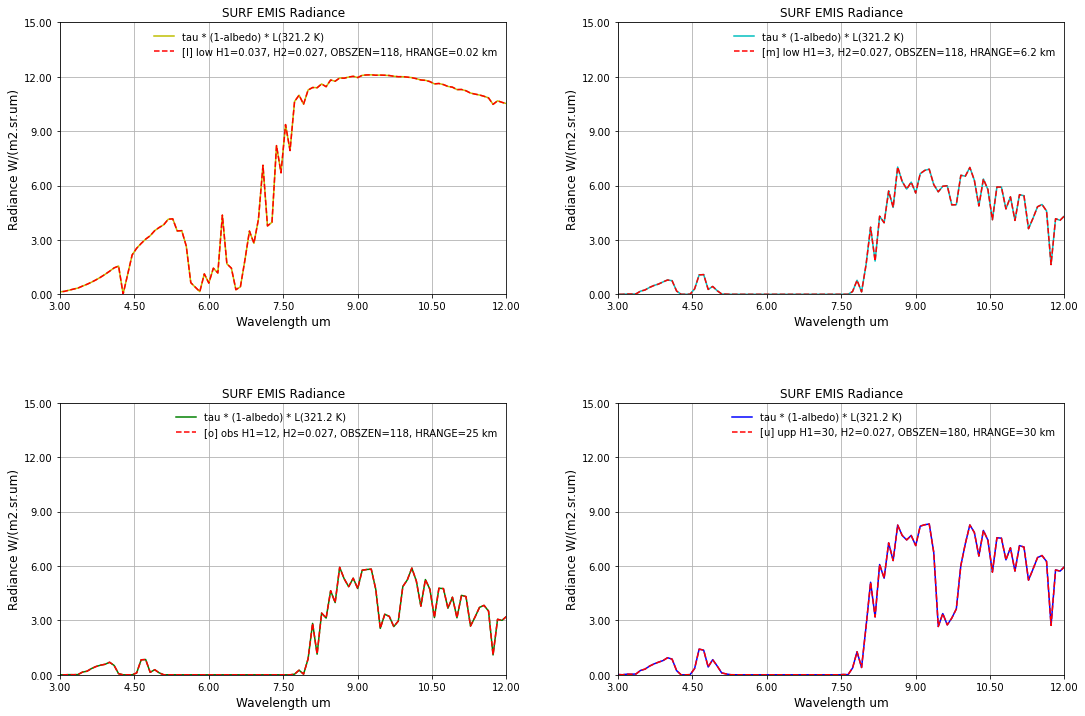

In [24]:
## to plot GRND RFLT data
pltaxs = [[0.3,1,0,500],[3,12,0,15]] 
for ip,pltax in enumerate(pltaxs):
    r = ryplot.Plotter(1+ip, 2, 2, figsize=(18,12))

    labl = [f"tau * (1-albedo) * L({Tsurf} K)"]
    r.plot(1,wavel['o'],Lsurf*tau['l'],label=labl,plotCol=dicPaths['l'][1])
    r.plot(1,wavel['o'],surfemis['l'],label=[dicPaths['l'][0]],plotCol='r',linestyle=['--'],
        ptitle='SURF EMIS Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(2,wavel['o'],Lsurf*tau['m'],label=labl,plotCol=dicPaths['m'][1])
    r.plot(2,wavel['o'],surfemis['m'],label=[dicPaths['m'][0]],plotCol='r',linestyle=['--'],
        ptitle='SURF EMIS Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(3,wavel['o'],Lsurf*tau['o'],label=labl,plotCol=dicPaths['o'][1])
    r.plot(3,wavel['o'],surfemis['o'],label=[dicPaths['o'][0]],plotCol='r',linestyle=['--'],
        ptitle='SURF EMIS Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(4,wavel['o'],Lsurf*tau['u'],label=labl,plotCol=dicPaths['u'][1])
    r.plot(4,wavel['o'],surfemis['u'],label=[dicPaths['u'][0]],plotCol='r',linestyle=['--'],
        ptitle='SURF EMIS Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);
    



Figures~\ref{fig:GRNDRFLT-0} and \ref{fig:GRNDRFLT-1} show that `GRND RFLT` appears to be the apparent ground radiance  at `H2`  as observed from `H1`, with non-unity-albedo ground-reflected solar irradiance *plus reflected sky irradiance*.
This is 
$$
\textrm{GRND RFLT} = \alpha \tau_\textrm{path} (\tau_\textrm{sun} \textrm{E}_\textrm{extra-terr} + E_\textrm{sky})/\pi
$$

Upward looking paths (such as `sun`) do not provide relevant `GRND RFLT`  values and is not considered here.

Given the poor visibility (hence, relatively high sky reflection contribution), there is a reasonable match in the NIR band between the Modtran results (solid colour lines) and the first-principles calculation using Modtran TAO irradiance and the Modtran transmittance values (black dashed lines).  

In the MWIR and LWIR spectral range there is no significant reflected sunlight, hence most of the GRND REFL radiance is thermal self radiation.
The graphs in Figure~\ref{fig:GRNDRFLT-1} show the value of 
$$\textrm{GRND RFLT} \approx\textrm{L}(\textrm{T}_\textrm{atmo})(1-\tau_\textrm{sky})\alpha$$
where the approximate  reflected thermal radiance calculated assuming the sky to be a blackbody with atmospheric temperature and an emissivity given by one minus the transmittance to space.  Although this is a rough approximation, the agreement is surprisingly good.

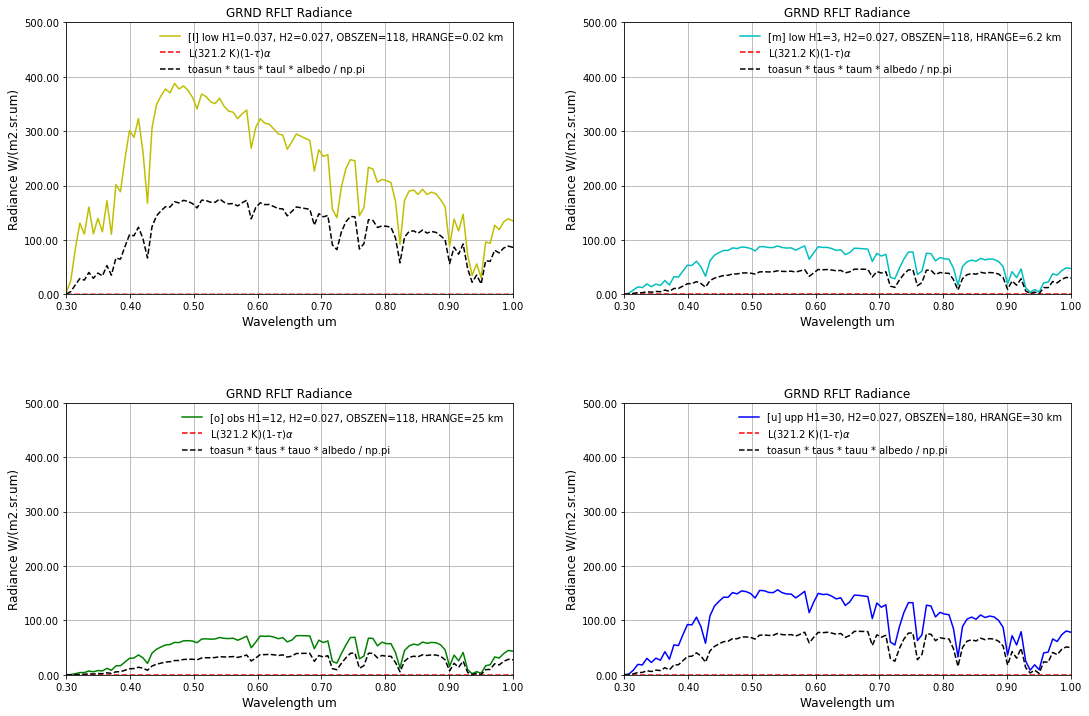

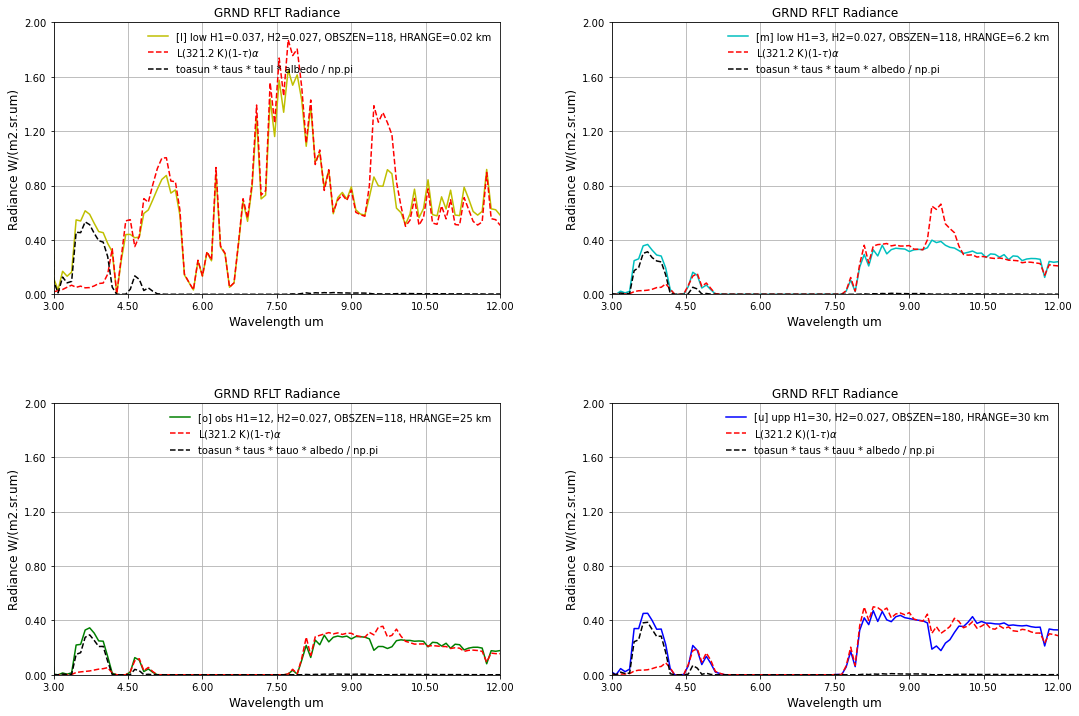

In [25]:
## to plot GRND RFLT data
pltaxs = [[0.3,1,0,500],[3,12,0,2]] 
for ip,pltax in enumerate(pltaxs):
    r = ryplot.Plotter(1+ip, 2, 2, figsize=(18,12))

    
    
    r.plot(1,wavel['o'],grndrflt['l'],label=[dicPaths['l'][0]],plotCol=dicPaths['l'][1])
    r.plot(1,wavel['o'],LTsky*(1-tau['u'])*albedo*tau['l'],label=[f"L({Tsurf} K)(1-$\\tau$)$\\alpha$"],plotCol='r',linestyle=['--'],)
    r.plot(1,wavel['o'],toasun*tau['s']*tau['l']*albedo/np.pi,label=['toasun * taus * taul * albedo / np.pi'],plotCol='k',linestyle=['--'],
        ptitle='GRND RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(2,wavel['o'],grndrflt['m'],label=[dicPaths['m'][0]],plotCol=dicPaths['m'][1])
    r.plot(2,wavel['o'],LTsky*(1-tau['u'])*albedo*tau['m'],label=[f"L({Tsurf} K)(1-$\\tau$)$\\alpha$"],plotCol='r',linestyle=['--'],)
    r.plot(2,wavel['o'],toasun*tau['s']*tau['m']*albedo/np.pi,label=['toasun * taus * taum * albedo / np.pi'],plotCol='k',linestyle=['--'],
        ptitle='GRND RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(3,wavel['o'],grndrflt['o'],label=[dicPaths['o'][0]],plotCol=dicPaths['o'][1])
    r.plot(3,wavel['o'],LTsky*(1-tau['u'])*albedo*tau['o'],label=[f"L({Tsurf} K)(1-$\\tau$)$\\alpha$"],plotCol='r',linestyle=['--'],)
    r.plot(3,wavel['o'],toasun*tau['s']*tau['o']*albedo/np.pi,label=['toasun * taus * tauo * albedo / np.pi'],plotCol='k',linestyle=['--'],
        ptitle='GRND RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(4,wavel['o'],grndrflt['u'],label=[dicPaths['u'][0]],plotCol=dicPaths['u'][1])
    r.plot(4,wavel['o'],LTsky*(1-tau['u'])*albedo*tau['u'],label=[f"L({Tsurf} K)(1-$\\tau$)$\\alpha$"],plotCol='r',linestyle=['--'],)
    r.plot(4,wavel['o'],toasun*tau['s']*tau['u']*albedo/np.pi,label=['toasun * taus * tauu * albedo / np.pi'],plotCol='k',linestyle=['--'],
        ptitle='GRND RFLT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);
    


Figures~\ref{fig:SOLSCATSINGSCAT-0} and \ref{fig:SOLSCATSINGSCAT-1} show the  relative magnitudes of single and multiple solar scattering along the path from H1 to H2.    There is not much to learn from these graphs.

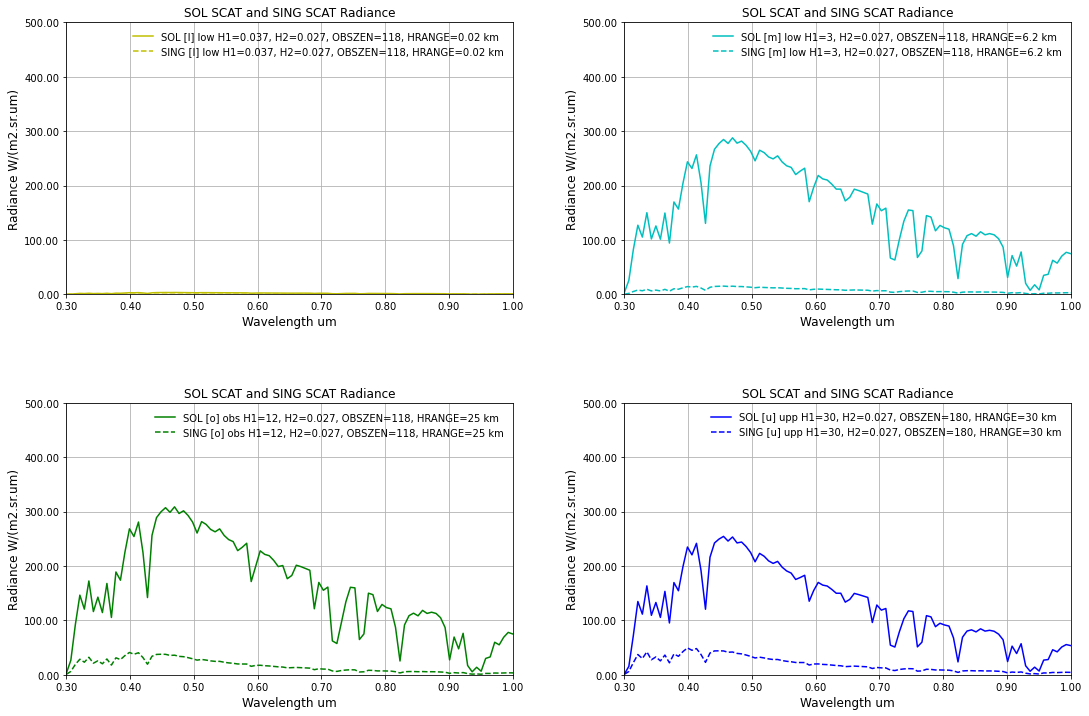

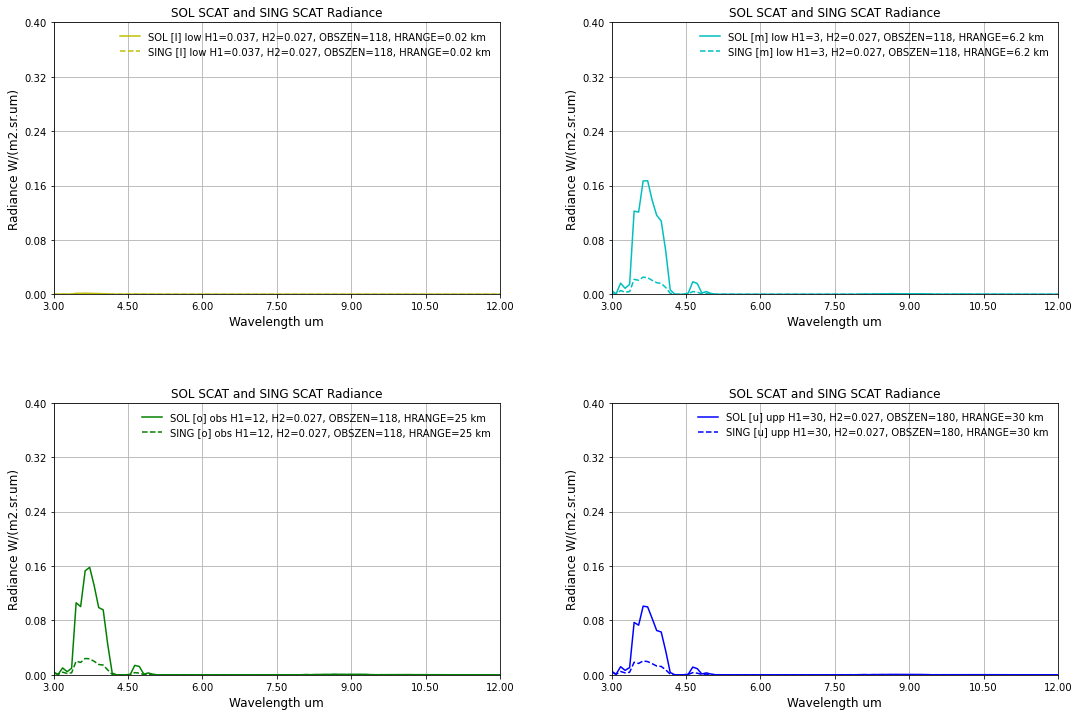

In [26]:
## to plot SOL SCAT and SING SCAT data

pltaxs = [[0.3,1,0,500],[3,12,0,0.4]] 
for ip,pltax in enumerate(pltaxs):
    r = ryplot.Plotter(1+ip, 2, 2, figsize=(18,12))
    

    r.plot(1,wavel['o'],solscat['l'],label=[f"SOL {dicPaths['l'][0]}"],plotCol=dicPaths['l'][1])
    r.plot(1,wavel['o'],singscat['l'],label=[f"SING {dicPaths['l'][0]}"],plotCol=dicPaths['l'][1],linestyle=['--'],
        ptitle='SOL SCAT and SING SCAT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(2,wavel['o'],solscat['m'],label=[f"SOL {dicPaths['m'][0]}"],plotCol=dicPaths['m'][1])
    r.plot(2,wavel['o'],singscat['m'],label=[f"SING {dicPaths['m'][0]}"],plotCol=dicPaths['m'][1],linestyle=['--'],
        ptitle='SOL SCAT and SING SCAT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(3,wavel['o'],solscat['o'],label=[f"SOL {dicPaths['o'][0]}"],plotCol=dicPaths['o'][1])
    r.plot(3,wavel['o'],singscat['o'],label=[f"SING {dicPaths['o'][0]}"],plotCol=dicPaths['o'][1],linestyle=['--'],
        ptitle='SOL SCAT and SING SCAT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

    r.plot(4,wavel['o'],solscat['u'],label=[f"SOL {dicPaths['u'][0]}"],plotCol=dicPaths['u'][1])
    r.plot(4,wavel['o'],singscat['u'],label=[f"SING {dicPaths['u'][0]}"],plotCol=dicPaths['u'][1],linestyle=['--'],
        ptitle='SOL SCAT and SING SCAT Radiance',xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
        pltaxis=pltax,maxNX=8);

Figures~\ref{fig:radcomponents-0} and \ref{fig:radcomponents-1} show the path radiance components for the different paths in the NIR, MWIR  and  LWIR spectral bands.  It is evident that the total radiance comprises the sum of (1) the path thermal radiance, (2) the surface emission/exitance, (3) the solar scatter and (4) the reflected ground  (including sky) radiance.   

TOTAL RAD = PTH THRML + SURF EMIS + SOL SCAT + GRND RFLT

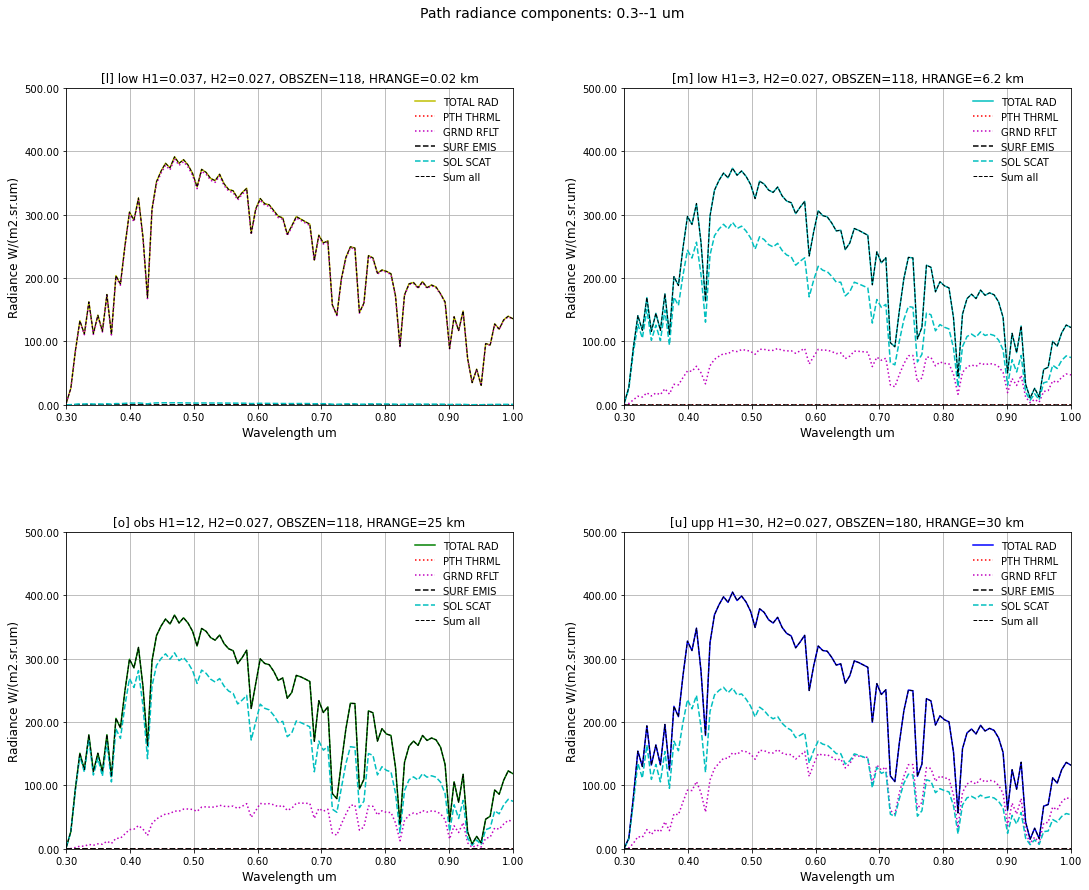

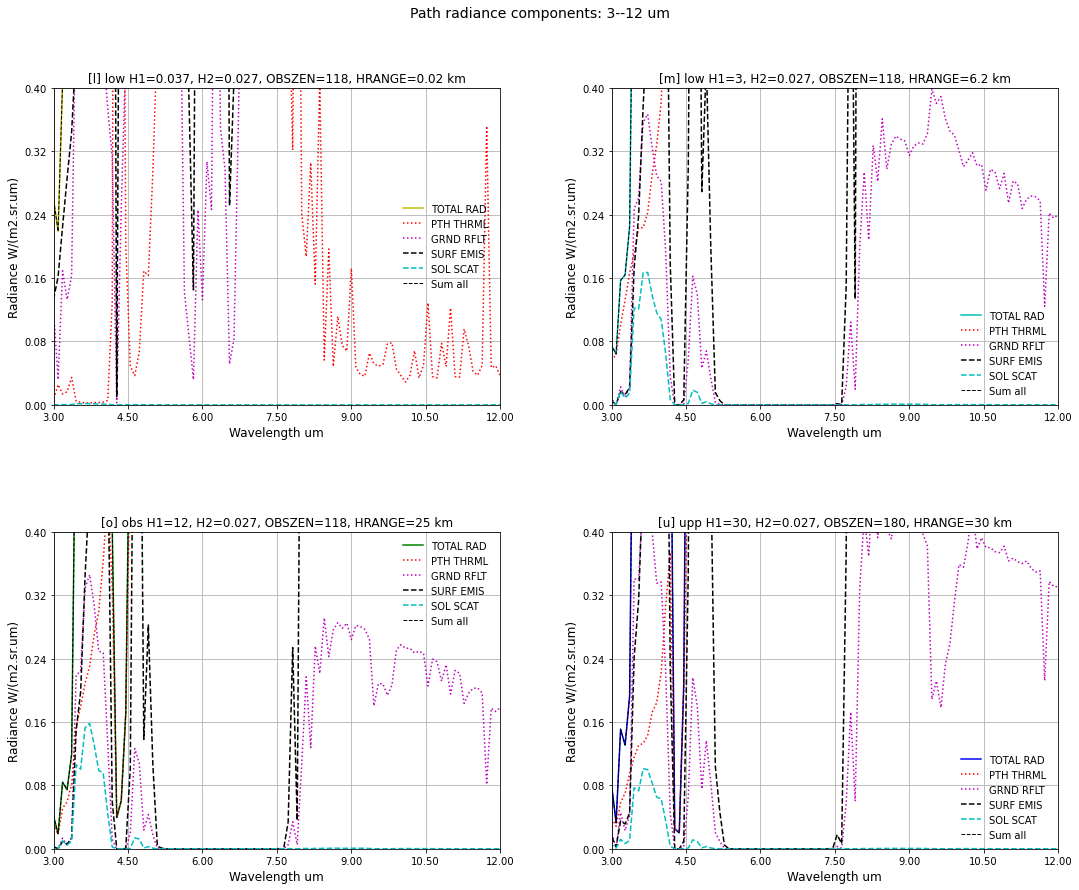

In [27]:
## to plot TOTAL RAD data


for ip,pltax in enumerate(pltaxs):
    r = ryplot.Plotter(ip+1, 2, 2, f'Path radiance components: {pltax[0]}--{pltax[1]} um',figsize=(18,14))
    for ip,path in enumerate(['l','m','o','u']):
        r.plot(ip+1,wavel['o'],totalrad[path],label=[f"TOTAL RAD "],plotCol=dicPaths[path][1])
        r.plot(ip+1,wavel['o'],pththrml[path],label=[f"PTH THRML "],plotCol='r',linestyle=[':'])
        r.plot(ip+1,wavel['o'],grndrflt[path],label=[f"GRND RFLT "],plotCol='m',linestyle=[':'])
        r.plot(ip+1,wavel['o'],surfemis[path],label=[f"SURF EMIS "],plotCol='k',linestyle=['--'])
        r.plot(ip+1,wavel['o'], solscat[path], label=[f"SOL SCAT "],plotCol='charteuse',linestyle=['--'])
        r.plot(ip+1,wavel['o'], pththrml[path]+solscat[path]+grndrflt[path]+surfemis[path], 
               label=[f"Sum all "],plotCol='k',linewidths=[1],linestyle=['--'],
            ptitle=f"{dicPaths[path][0]}",xlabel='Wavelength um',ylabel='Radiance W/(m2.sr.um)',
            pltaxis=pltax,maxNX=8);


## Summary

Figure~\ref{fig:pathgeometry02} shows the definitions of the data in the tape7 file.  These definitions are supported by the numerical results shown in this report. 

![](images/pathgeometry02.png)

In [28]:
###
# /    tape7        modtran code parameter
#     //    ----------------------------------------

#     //    PTH THRML    RADCUM = DIRECT + MULTIPLY SCATTERED THERMAL PATH RADIANCE
#     //    THRML SCT    SUMTMS
#     //    SURF EMIS    BBG = SURFACE EMISSION
#     //    SOL SCAT     SUMSSR = SINGLE + MULTIPLE SOLAR SCATTERED RADIANCE
#     //    SING SCAT    SUMSSS

#     //    TOTAL RAD    SUMT = PTH THRML + SURF EMIS + SOL SCAT + GRND RFLT


#     //    FREQ         V
#     //    TOT TRANS    TX(9)
#     //    GRND RFLT    RFSURF = REFLECTED SURFACE TERM
#     //    DRCT RFLT    RFLSS
#     //    REF SOL      TSNREF
#     //    SOL@OBS      TSNOBS
#     //    DEPTH        ALTX9